# Elastic Net: The Hybrid Approach

**Business Question**: Can we combine the benefits of Ridge and LASSO for diamond pricing?

This notebook demonstrates Elastic Net regression, which combines Ridge's group effect (keeping related variables together) with LASSO's sparsity (eliminating weak predictors), showing when and why this hybrid approach is superior.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand how Elastic Net combines Ridge and LASSO benefits
- Use the alpha parameter to control Ridge vs LASSO balance
- Apply Elastic Net for both feature selection and coefficient stabilization
- Compare Elastic Net with Ridge and LASSO regression
- Select optimal alpha and lambda parameters using cross-validation


In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## Data Preparation


In [2]:
# Load diamonds dataset
diamonds = sns.load_dataset('diamonds')

# Create dummy variables for categorical features
diamonds_encoded = pd.get_dummies(diamonds, columns=['cut', 'color', 'clarity'], drop_first=True)

# Separate features and target
X = diamonds_encoded.drop('price', axis=1)
y = diamonds_encoded['price']

print("Dataset shape:", diamonds_encoded.shape)
print("Number of features:", X.shape[1])
print("Feature names:", X.columns.tolist()[:10], "...")  # Show first 10 features

# Standardize features (crucial for Elastic Net)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Dataset shape: (53940, 24)
Number of features: 23
Feature names: ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair'] ...


## Understanding Elastic Net: The Hybrid Approach


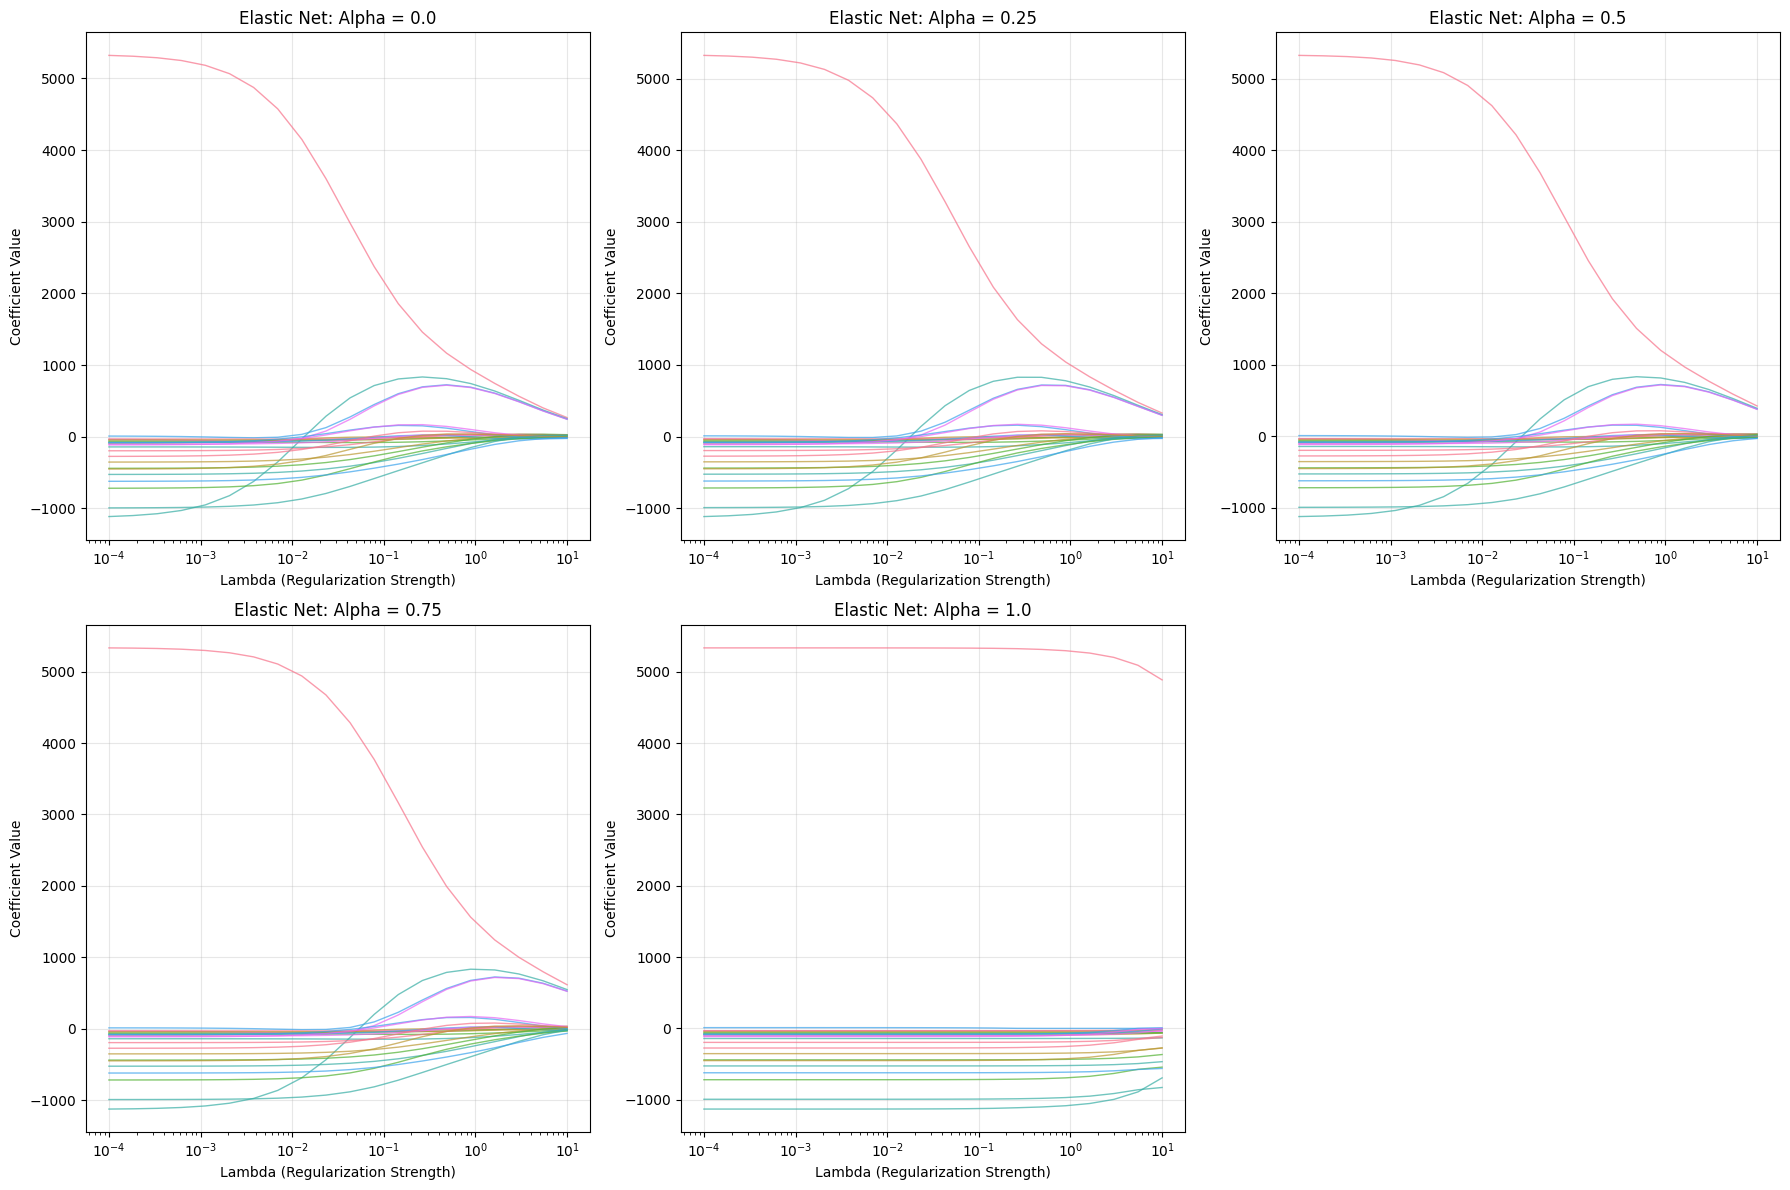

Elastic Net Alpha Parameter:
Alpha = 0.0: Pure Ridge (L2 penalty only)
Alpha = 0.25: 25% LASSO, 75% Ridge
Alpha = 0.5: 50% LASSO, 50% Ridge
Alpha = 0.75: 75% LASSO, 25% Ridge
Alpha = 1.0: Pure LASSO (L1 penalty only)


In [3]:
# Test different alpha values (0 = Ridge, 1 = LASSO, 0.5 = 50/50 mix)
alpha_values = [0.0, 0.25, 0.5, 0.75, 1.0]
lambda_values = np.logspace(-4, 1, 20)  # From 0.0001 to 10

# Store results for comparison
results = {}

for alpha in alpha_values:
    coefs_alpha = []
    for l1_ratio in lambda_values:
        elastic_net = ElasticNet(alpha=l1_ratio, l1_ratio=alpha, max_iter=10000)
        elastic_net.fit(X_scaled, y)
        coefs_alpha.append(elastic_net.coef_)
    
    results[alpha] = np.array(coefs_alpha)

# Create coefficient path plots for different alpha values
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, alpha in enumerate(alpha_values):
    ax = axes[i]
    coefs = results[alpha]
    
    # Plot coefficient paths
    for j, col in enumerate(X.columns):
        ax.plot(lambda_values, coefs[:, j], alpha=0.7, linewidth=1)
    
    ax.set_xlabel('Lambda (Regularization Strength)')
    ax.set_ylabel('Coefficient Value')
    ax.set_title(f'Elastic Net: Alpha = {alpha}')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

print("Elastic Net Alpha Parameter:")
print("="*40)
print("Alpha = 0.0: Pure Ridge (L2 penalty only)")
print("Alpha = 0.25: 25% LASSO, 75% Ridge")
print("Alpha = 0.5: 50% LASSO, 50% Ridge")
print("Alpha = 0.75: 75% LASSO, 25% Ridge")
print("Alpha = 1.0: Pure LASSO (L1 penalty only)")


## Cross-Validation for Parameter Selection


In [4]:
# Grid search for optimal parameters
param_grid = {
    'alpha': np.logspace(-4, 1, 20),
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

elastic_net = ElasticNet(max_iter=10000)
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

print("Best parameters:")
print(f"Alpha: {grid_search.best_params_['alpha']:.4f}")
print(f"L1 Ratio: {grid_search.best_params_['l1_ratio']:.2f}")
print(f"Best CV Score: {-grid_search.best_score_:.2f}")

# Compare with Ridge and LASSO
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_scaled, y)

lasso = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
lasso.fit(X_scaled, y)

# Get coefficients
elastic_coefs = grid_search.best_estimator_.coef_
ridge_coefs = ridge.coef_
lasso_coefs = lasso.coef_

# Count non-zero coefficients
elastic_nz = np.sum(elastic_coefs != 0)
ridge_nz = np.sum(ridge_coefs != 0)
lasso_nz = np.sum(lasso_coefs != 0)

print(f"\nModel Comparison:")
print(f"{'Model':<15} {'Non-zero Coefs':<15} {'R²':<10} {'MSE':<10}")
print("-" * 50)
print(f"{'Elastic Net':<15} {elastic_nz:<15} {grid_search.best_estimator_.score(X_scaled, y):<10.4f} {mean_squared_error(y, grid_search.best_estimator_.predict(X_scaled)):<10.2f}")
print(f"{'Ridge':<15} {ridge_nz:<15} {ridge.score(X_scaled, y):<10.4f} {mean_squared_error(y, ridge.predict(X_scaled)):<10.2f}")
print(f"{'LASSO':<15} {lasso_nz:<15} {lasso.score(X_scaled, y):<10.4f} {mean_squared_error(y, lasso.predict(X_scaled)):<10.2f}")


Best parameters:
Alpha: 0.0001
L1 Ratio: 1.00
Best CV Score: 2236055.74

Model Comparison:
Model           Non-zero Coefs  R²         MSE       
--------------------------------------------------
Elastic Net     23              0.9198     1276545.17
Ridge           23              0.9198     1276545.17
LASSO           23              0.9198     1276545.17


## Key Takeaways

### **Elastic Net Benefits:**

1. **Combines Ridge and LASSO**: Gets both coefficient stabilization and feature selection
2. **Flexible Parameter Control**: Alpha parameter controls Ridge vs LASSO balance
3. **Group Effect**: Keeps related variables together (like Ridge)
4. **Sparsity**: Eliminates weak predictors (like LASSO)

### **When to Use Elastic Net:**

- **High-dimensional data** with many features
- **Correlated predictors** that should be kept together
- **Need both stability and interpretability**
- **Uncertain about feature importance**

### **Parameter Selection:**

- **Alpha = 0**: Pure Ridge (stabilization only)
- **Alpha = 1**: Pure LASSO (selection only)  
- **Alpha = 0.5**: Balanced approach (recommended starting point)
